In [1]:
%matplotlib inline

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

## Generate powerlaw distributed stellar mass

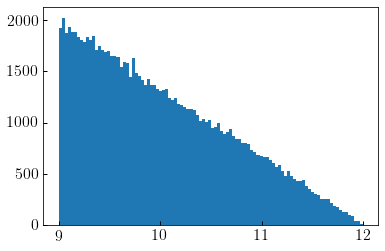

In [3]:
from scipy.stats import powerlaw

ngals_tot = int(1e5)
slope = 2
log_mstar = 3*(1-powerlaw.rvs(slope, size=ngals_tot)) + 9
galaxy_mstar = 10**log_mstar
fig, ax = plt.subplots(1, 1)

__=ax.hist(log_mstar, bins=100)

##  Model the quenched fraction vs. $M_{\ast}$ with an exponential

In [4]:
log_mstar_crit = 10.5
uran = np.random.rand(ngals_tot)
is_quenched = uran < 1-np.exp(-(log_mstar/log_mstar_crit)**5)

num_quenched = np.count_nonzero(is_quenched)
num_star_forming = ngals_tot - num_quenched

##  Generate quenched sequence SFR using exponential power 

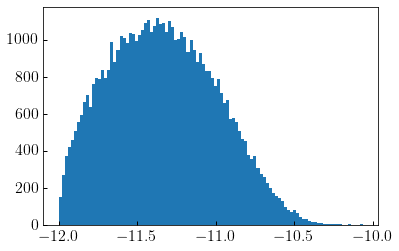

In [5]:
from scipy.stats import exponpow

b = 1.5
log_ssfr_quenched = exponpow.rvs(b, loc=-12, scale=1, size=num_quenched)
ssfr_quenched = 10**log_ssfr_quenched

fig, ax = plt.subplots(1, 1)

__=ax.hist(log_ssfr_quenched, bins=100)

##  Generate star-forming sequence SFR using log-normal

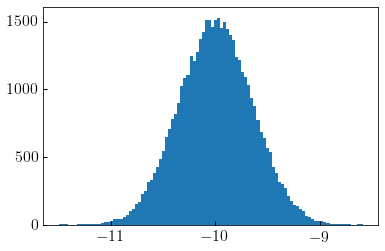

In [6]:
log_ssfr_main_sequence = np.random.normal(loc=-10, scale=0.35, size=num_star_forming)
ssfr_star_forming = 10**log_ssfr_main_sequence

fig, ax = plt.subplots(1, 1)

__=ax.hist(log_ssfr_main_sequence, bins=100)

## Build composite galaxy population

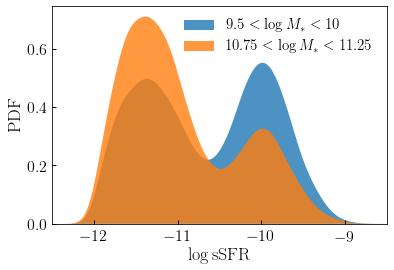

In [7]:
galaxy_ssfr = np.zeros_like(galaxy_mstar)
galaxy_ssfr[is_quenched] = ssfr_quenched
galaxy_ssfr[~is_quenched] = ssfr_star_forming

logsm_low, logsm_high = 9.5, 10
mask1 = (log_mstar >= logsm_low) & (log_mstar < logsm_high)

logsm_low, logsm_high = 10.75, 11.25
mask2 = (log_mstar >= logsm_low) & (log_mstar < logsm_high)

fig, ax = plt.subplots(1, 1)

from scipy.stats import gaussian_kde
kde1 = gaussian_kde(np.log10(galaxy_ssfr[mask1]))
kde2 = gaussian_kde(np.log10(galaxy_ssfr[mask2]))

x = np.linspace(-12.5, -8, 1000)
pdf1 = kde1.evaluate(x)
pdf2 = kde2.evaluate(x)

__=ax.fill(x, pdf1, alpha=0.8, label=r'$9.5 < \log M_{\ast} < 10$')
__=ax.fill(x, pdf2, alpha=0.8, label=r'$10.75 < \log M_{\ast} < 11.25$')

xlim = ax.set_xlim(-12.5, -8.5)
ylim = ax.set_ylim(ymin=0)
legend = ax.legend()

xlabel = ax.set_xlabel(r'$\log{\rm sSFR}$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')

figname = 'cam_example_complex_sfr.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

## Build a baseline model of stellar mass

In [8]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog()

from halotools.empirical_models import Moster13SmHm
model = Moster13SmHm()

halocat.halo_table['stellar_mass'] = model.mc_stellar_mass(
    prim_haloprop=halocat.halo_table['halo_mpeak'], redshift=0)

print(halocat.halo_table.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_xoff', 'halo_spin', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo', 'stellar_mass']


In [9]:
from halotools.empirical_models import conditional_abunmatch_bin_free

x = halocat.halo_table['stellar_mass']
y = halocat.halo_table['halo_dmvir_dt_100myr']

x2 = galaxy_mstar
y2 = np.log10(galaxy_ssfr)

nwin = 201

halocat.halo_table['log_ssfr'] = conditional_abunmatch_bin_free(x, y, x2, y2, nwin)

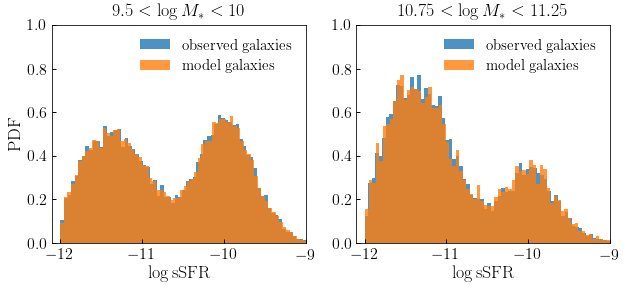

In [10]:
logsm_low, logsm_high = 9.5, 10
mask1_gals = (log_mstar >= logsm_low) & (log_mstar < logsm_high)
mask1_halos = (np.log10(halocat.halo_table['stellar_mass']) >= logsm_low)
mask1_halos *= (np.log10(halocat.halo_table['stellar_mass']) < logsm_high)

logsm_low, logsm_high = 10.75, 11.25
mask2_gals = (log_mstar >= logsm_low) & (log_mstar < logsm_high)
mask2_halos = (np.log10(halocat.halo_table['stellar_mass']) >= logsm_low)
mask2_halos *= (np.log10(halocat.halo_table['stellar_mass']) < logsm_high)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

__=ax1.hist(np.log10(galaxy_ssfr[mask1_gals]), bins=75, normed=True, alpha=0.8, 
          label=r'${\rm observed\ galaxies}$')
__=ax1.hist(halocat.halo_table['log_ssfr'][mask1_halos], bins=75, normed=True, alpha=0.8,
          label=r'${\rm model\ galaxies}$')
__=ax2.hist(np.log10(galaxy_ssfr[mask2_gals]), bins=75, normed=True, alpha=0.8, 
          label=r'${\rm observed\ galaxies}$')
__=ax2.hist(halocat.halo_table['log_ssfr'][mask2_halos], bins=75, normed=True, alpha=0.8,
          label=r'${\rm model\ galaxies}$')

legend1 = ax1.legend()
legend2 = ax2.legend()

ylim1 = ax1.set_ylim(0, 1)
xlim1 = ax1.set_xlim(-12.1, -9)
ylim2 = ax2.set_ylim(0, 1)
xlim2 = ax2.set_xlim(-12.1, -9)

xlabel1 = ax1.set_xlabel(r'$\log{\rm sSFR}$')
xlabel2 = ax2.set_xlabel(r'$\log{\rm sSFR}$')
ylabel1 = ax1.set_ylabel(r'${\rm PDF}$')
title1 = ax1.set_title(r'$9.5 < \log M_{\ast} < 10$')
title2 = ax2.set_title(r'$10.75 < \log M_{\ast} < 11.25$')

figname = 'cam_example_complex_sfr_recovery.png'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')